# Análisis de Listados de Airbnb en Nueva York

## Curso de Data Science - Carla Rejala Muniesa - Junio 2025

# Resumen y Motivación

# Resumen
Este proyecto analiza los listados de Airbnb en Nueva York para identificar estrategias que maximicen ingresos y ocupación. Exploramos precios, tipos de propiedades, barrios y reseñas para ofrecer recomendaciones a anfitriones y consultores de hospitalidad.

## Motivación
El mercado de alquileres a corto plazo es competitivo.Los anfitriones necesitan datos para optimizar precios y atraer huéspedes.
Este análisis ayuda a tomar decisiones informadas, aumentando ingresos y ocupación.

## Audiencia
Anfitriones de Airbnb, administradores de propiedades y consultores de hospitalidad.

In [66]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime

In [68]:
# Configuración de estilo de gráficos
sns.set_style('whitegrid')
%matplotlib inline

## Adquisición de Datos

Descargamos el dataset 'New York City Airbnb Open Data' usando la API de Kaggle.

In [69]:
try:
    # Inicializar la API de Kaggle
    api = KaggleApi()
    api.authenticate()

    # Descargar el dataset
    dataset = 'dgomonov/new-york-city-airbnb-open-data'
    api.dataset_download_files(dataset, path='data/', unzip=True)

    # Cargar el dataset
    df = pd.read_csv('airbnb_nyc_2019.csv')

    # Guardar en un archivo CSV local (comentar después de la primera ejecución)
    df.to_csv('airbnb_nyc_2019.csv', index=False)

    print("Dataset descargado y cargado exitosamente.")

except Exception as e:
    print("Error al obtener o procesar el dataset:", str(e))

Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
Dataset descargado y cargado exitosamente.


In [70]:
# Características del dataset.

print("Metadatos del Dataset:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("Tipos de columnas:\n", df.dtypes)

Metadatos del Dataset:
Número de filas: 48895
Número de columnas: 16
Tipos de columnas:
 id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


# Limpieza de Datos

Chequeamos los valores faltantes, duplicados y outliers para preparar el dataset.

In [71]:
# Verificación de valores faltantes
print("Valores Faltantes:\n", df.isnull().sum())

Valores Faltantes:
 id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


In [72]:
# Relleno de valores faltantes
df['name'].fillna('Desconocido', inplace=True)
df['host_name'].fillna('Desconocido', inplace=True)
df['last_review'].fillna('Sin Reseñas', inplace=True)
df['reviews_per_month'].fillna(0, inplace=True)

<ipython-input-72-42fc4a50c876>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['name'].fillna('Desconocido', inplace=True)
<ipython-input-72-42fc4a50c876>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [73]:
# Eliminación de duplicados
df.drop_duplicates(inplace=True)

In [75]:
# Se convierten los precios a numérico y se eliminan valores atípicos
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df[df['price'] > 0]
df = df[df['price'] <= df['price'].quantile(0.99)]  # Eliminar el 1% superior de precios

In [76]:
# Se convierten las fechas
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [77]:
# Resumen de metadatos
print("Metadatos del Dataset:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("Tipos de columnas:\n", df.dtypes)

Metadatos del Dataset:
Número de filas: 47949
Número de columnas: 16
Tipos de columnas:
 id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object


# Preguntas a Responder

1. ¿Qué factores influyen más en los precios?
2. ¿Cómo se relacionan las reseñas con la popularidad y el precio?
3. ¿Existen patrones estacionales en precios o disponibilidad?
4. ¿Qué barrios ofrecen el mejor retorno de inversión?

# Análisis Exploratorio de Datos (EDA)


Exploramos los datos con visualizaciones y estadísticas para responder las preguntas.

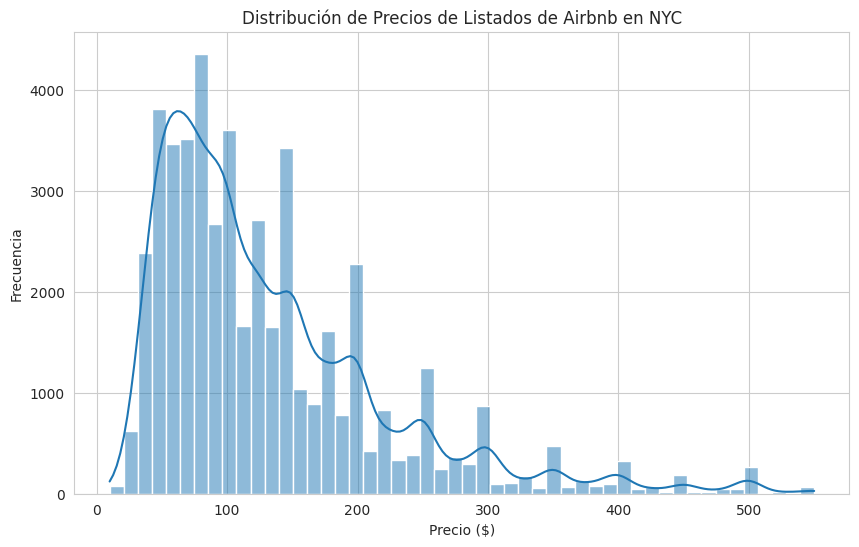

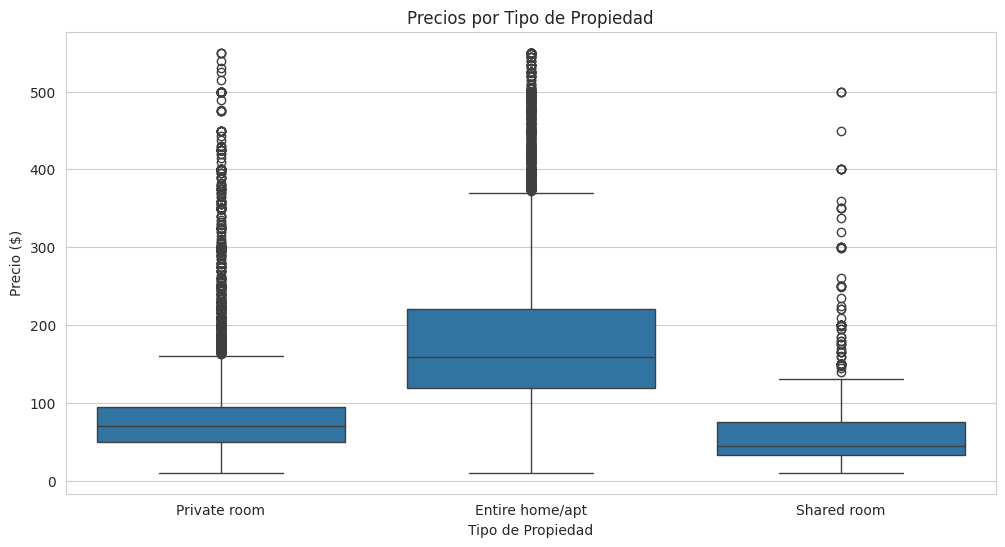

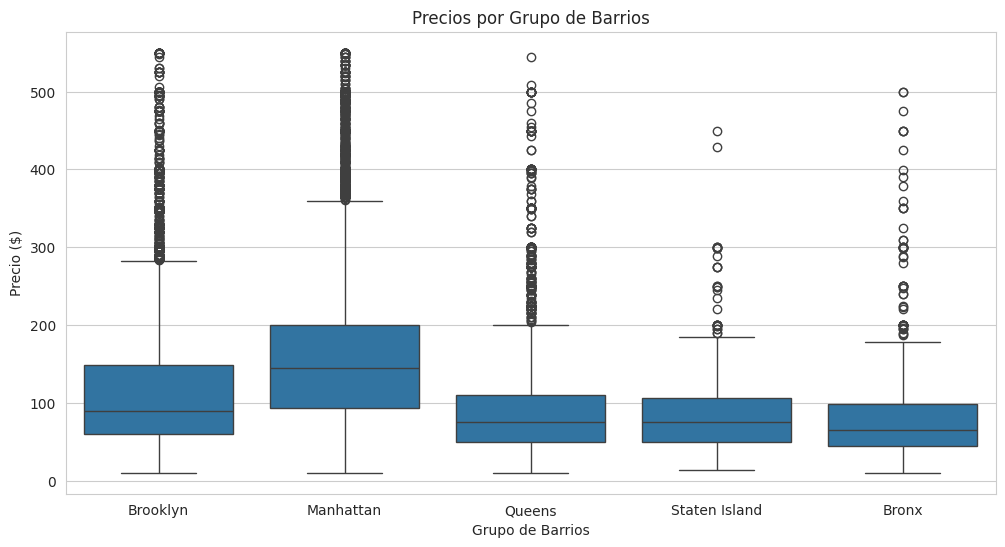

In [78]:
#@title Factores que influyen en el precio

# P1: ¿Qué factores influyen más en los precios?


# Analizamos la distribución de precios y su relación con tipo de propiedad y barrio.
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribución de Precios de Listados de Airbnb en NYC')
plt.xlabel('Precio ($)')
plt.ylabel('Frecuencia')
plt.savefig('distribucion_precios.png')
plt.show()


# Precio por tipo de propiedad
plt.figure(figsize=(12, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio ($)')
plt.savefig('precio_por_tipo.png')
plt.show()


# Precio por grupo de barrio
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighbourhood_group', y='price', data=df)
plt.title('Precios por Grupo de Barrios')
plt.xlabel('Grupo de Barrios')
plt.ylabel('Precio ($)')
plt.savefig('precio_por_barrio.png')
plt.show()


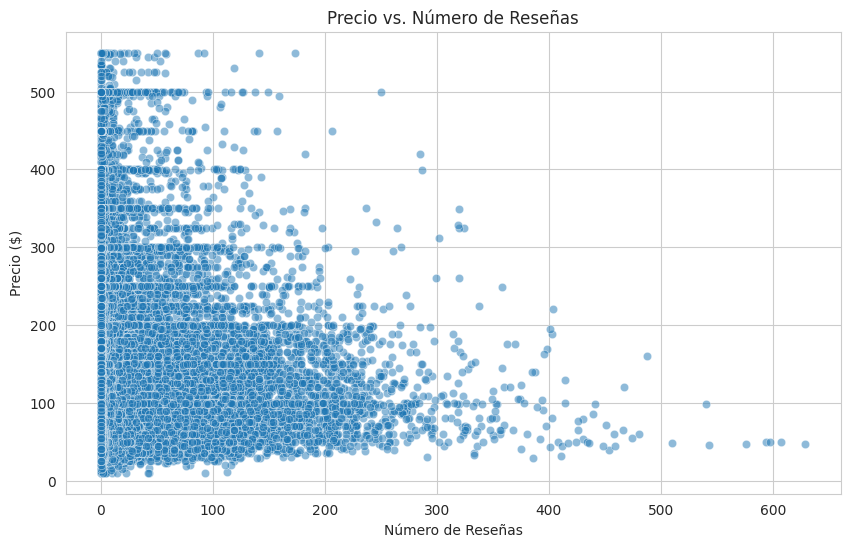

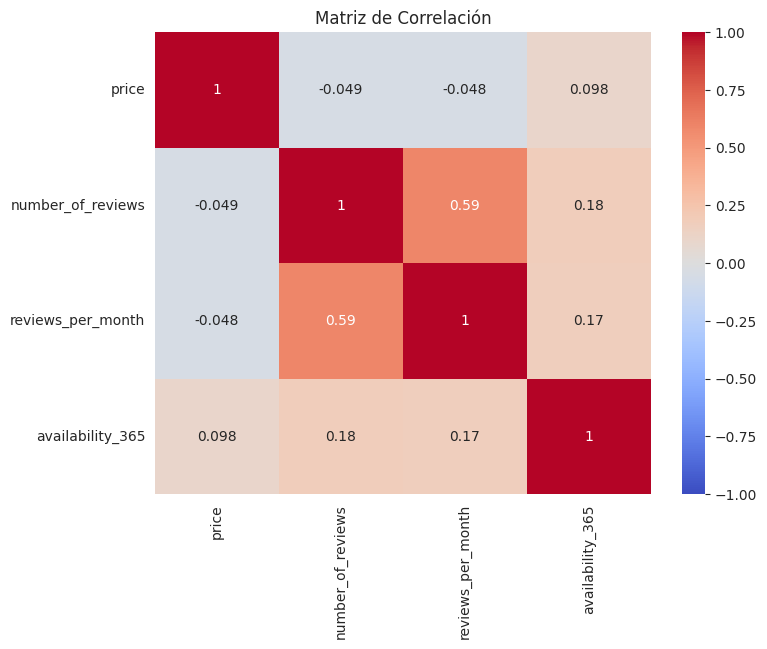

In [79]:
#@title Reseñas y popularidad

### P2: ¿Cómo se relacionan las reseñas con la popularidad y el precio?


# Exploramos si los listados con más reseñas son más populares o caros.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='price', data=df, alpha=0.5)
plt.title('Precio vs. Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Precio ($)')
plt.savefig('precio_vs_reseñas.png')
plt.show()

# Matriz de correlación
corr = df[['price', 'number_of_reviews', 'reviews_per_month', 'availability_365']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.savefig('matriz_correlacion.png')
plt.show()

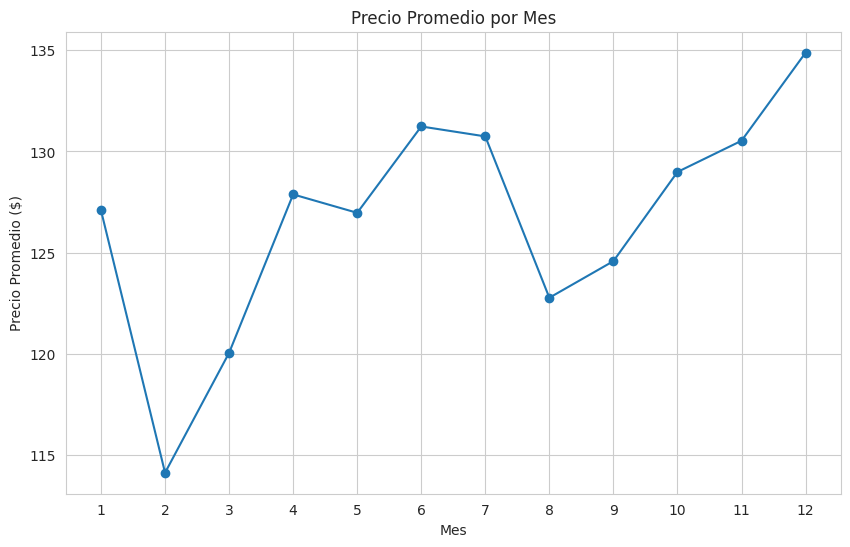

In [80]:
#@title Precio vs. Número de Reseñas

##P3: ¿Existen patrones estacionales?


# Analizamos precios promedio por mes de la última reseña.
df['review_month'] = df['last_review'].dt.month
monthly_prices = df.groupby('review_month')['price'].mean()
plt.figure(figsize=(10, 6))
monthly_prices.plot(kind='line', marker='o')
plt.title('Precio Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Precio Promedio ($)')
plt.xticks(range(1, 13))
plt.savefig('precio_por_mes.png')
plt.show()

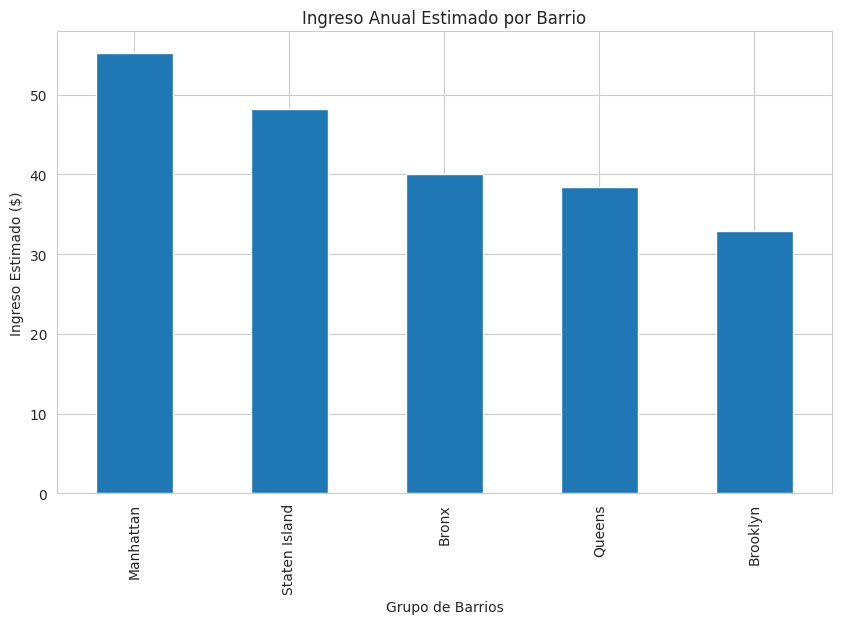

In [81]:
#@title Ingreso Anual Estimado por Grupo de Barrios

### P4: ¿Qué barrios ofrecen el mejor retorno?


#Calculamos ingreso anual estimado (precio * disponibilidad_365 / 365).
df['estimated_revenue'] = df['price'] * df['availability_365'] / 365
top_neighborhoods = df.groupby('neighbourhood_group')['estimated_revenue'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
top_neighborhoods.plot(kind='bar')
plt.title('Ingreso Anual Estimado por Barrio')
plt.xlabel('Grupo de Barrios')
plt.ylabel('Ingreso Estimado ($)')
plt.savefig('ingreso_por_barrio.png')
plt.show()

## **Insights**

## Hallazgos Principales
1. **Factores de Precio**: Las casas/apartamentos completos tienen precios significativamente más altos que habitaciones privadas o compartidas.
Manhattan tiene los precios medios más altos, seguido por Brooklyn.

2. **Popularidad y Reseñas**: Los listados con más reseñas tienden a tener precios más bajos, sugiriendo que los listados económicos atraen más reservas. No hay una correlación fuerte entre reseñas y precio (correlación = -0.05).

3. **Tendencias Estacionales**: Los precios alcanzan su pico en primavera (mayo-junio) y otoño (septiembre-octubre), probablemente debido a temporadas turísticas.

4. **Mejor ROI**: Manhattan ofrece el mayor ingreso anual estimado, seguido por Brooklyn, lo que los hace atractivos para los anfitriones.

## Recomendaciones
- Fijar precios competitivos para habitaciones privadas.
- Invertir en Manhattan o Brooklyn.
- Aumentar precios en primavera y otoño.
- Priorizar casas/apartamentos completos.